# Sparse Operations in Devito

Devito provides a robust API for sparse operations, encompassing two crucial functionalities: `injection` and `interpolation`. These operations are fundamental for handling sparse data, such as point sources and measurements, within numerical simulations.

The `injection` operation involves injecting values at specified sparse positions, simulating scenarios like point sources in physical systems. Mathematically, if we denote a `SparseTimeFunction` as $ S(t, x_s) $, where $ t $ represents time and $ x_s $ denotes sparse spatial coordinates, the injection operation can be expressed as:

$$
u(t, x) = u(t, x) + S(t, x_s) \cdot \delta(x - x_s)
$$

Here, $ \delta(x - x_s) $ is the Dirac delta functions, and $ t $ and $ x_s $ represent the time and sparse spatial coordinates of the injection point, respectively.

On the other hand, the `interpolation` operation reads the values of a field at sparse positions, mimicking point measurements. If $ F(t, x) $ is a field ('Function') defined on the full grid, the interpolation operation can be expressed as:

$$
I(t, r) = F(t, x_r)
$$

Here, $ I(t, r) $ represents the interpolated values at time $ t $ and sparse spatial coordinates $ x_r $.

In Devito, sparse operations are defined as methods for various sparse function types, including `SparseFunction`, `SparseTimeFunction`, `PrecomputedSparseFunction`, and `PrecomputedSparseTimeFunction`. For practicality, this tutorial focuses on time-dependent functions, but it's crucial to note that all operations discussed here apply to spatial-only functions as well.


In [1]:
from devito import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator

In [2]:
grid = Grid((51, 51))
nt = 11
f = TimeFunction(name="f", grid=grid, space_order=4)
u = TimeFunction(name="u", grid=grid, space_order=4, save=nt)

We first define five sparse positions for the purpose of this tutorial. We consider four points in a 2D grid intentionally not aligned with the grid points to highlight the interpolation and injection operations.

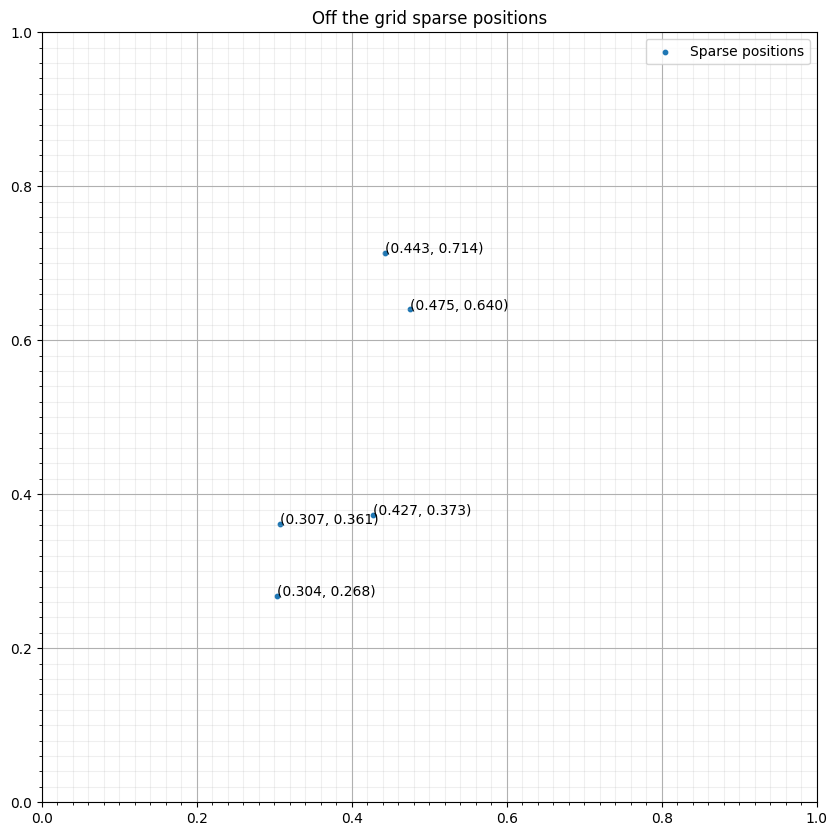

In [3]:
#NBVAL_IGNORE_OUTPUT
npoint = 5
coords = np.random.rand(npoint, 2)/2 + .25
base = np.floor(coords / grid.spacing)*grid.spacing


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.scatter(coords[:, 0], coords[:, 1], s=10, label="Sparse positions")
ax.grid(which = "major")
ax.grid(which = "minor", alpha = 0.2)
ax.xaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.yaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.set_title("Off the grid sparse positions")
for i in range(npoint):
    ax.annotate("(%.3f, %.3f)" % (coords[i, 0], coords[i, 1]), coords[i, :])
ax.legend()
plt.show()

## SparseFunction

A `SparseFunction` is a devito object representing a `Function` defined at sparse positions. It contains the coordinates of the sparse positions and the data at those positions. The coordinates are stored in a `SubFunction` object as a `Function` of shape `(npoints, ndim)` where `npoints` is the number of sparse positions and `ndim` is the number of dimension of the grid.

A `SparseFunction` comes with the two main methods `inject(field, expr)` and `interpolate(field)` that respectively inject `expr` into `field` at the sparse positons and interpolate `field` at the sparse positions.

In [4]:
print(SparseTimeFunction.__doc__)


    Tensor symbol representing a space- and time-varying sparse array in symbolic
    equations.

    Like SparseFunction, SparseTimeFunction carries multi-dimensional data that
    are not aligned with the computational grid. As such, each data value is
    associated some coordinates.
    A SparseTimeFunction provides symbolic interpolation routines to convert
    between TimeFunctions and sparse data points. These are based upon standard
    [bi,tri]linear interpolation.

    Parameters
    ----------
    name : str
        Name of the symbol.
    npoint : int
        Number of sparse points.
    nt : int
        Number of timesteps along the time Dimension.
    grid : Grid
        The computational domain from which the sparse points are sampled.
    coordinates : np.ndarray, optional
        The coordinates of each sparse point.
    space_order : int, optional, default=0
        Discretisation order for space derivatives.
    time_order : int, optional, default=1
        Discreti

### Multilinear interpolation

In [5]:
from itertools import product

In [6]:
s = SparseTimeFunction(name="s", grid=grid, npoint=npoint, nt=nt, coordinates=coords)

d1, d2 = grid.spacing
interp_points = np.concatenate([base+(s1*d1, s2*d2) for (s1, s2) in s._point_support])

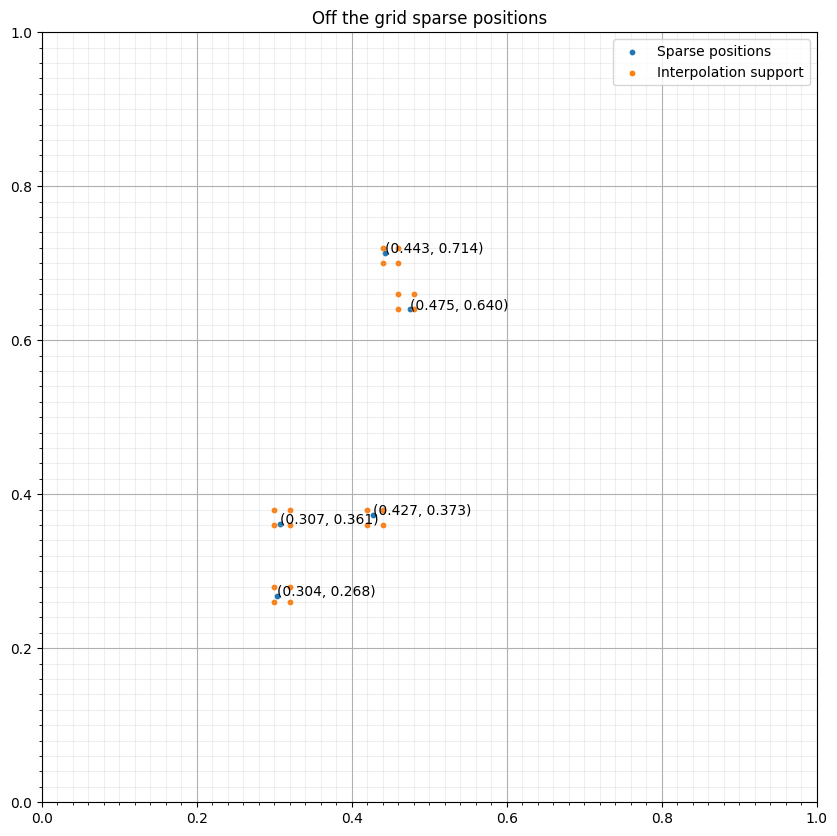

In [7]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.scatter(coords[:, 0], coords[:, 1], s=10, label="Sparse positions")
ax.scatter(interp_points[:, 0], interp_points[:, 1], s=10, label="Interpolation support")
ax.grid(which = "major")
ax.grid(which = "minor", alpha = 0.2)
ax.xaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.yaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.set_title("Off the grid sparse positions")
for i in range(npoint):
    ax.annotate("(%.3f, %.3f)" % (coords[i, 0], coords[i, 1]), coords[i, :])
ax.legend()
plt.show()

We first look at the interpolation section and how it is internally lowered into a linear interpolation method.

In [8]:
print("\n".join([str(s) for s in s.interpolate(f).evaluate]))

Eq(posx, (int)(floor((-o_x + s_coords(p_s, 0))/h_x)))
Eq(posy, (int)(floor((-o_y + s_coords(p_s, 1))/h_y)))
Eq(px, -floor((-o_x + s_coords(p_s, 0))/h_x) + (-o_x + s_coords(p_s, 0))/h_x)
Eq(py, -floor((-o_y + s_coords(p_s, 1))/h_y) + (-o_y + s_coords(p_s, 1))/h_y)
Eq(sum, 0.0)
Inc(sum, (rsx*px + (1 - rsx)*(1 - px))*(rsy*py + (1 - rsy)*(1 - py))*f(t, rsx + posx, rsy + posy))
Eq(s(time, p_s), sum)


In [9]:
f.data.fill(0)
op = Operator([Eq(f.forward, f+1)] + s.interpolate(f))

In [10]:
#NBVAL_IGNORE_OUTPUT
op()
s.data

Operator `Kernel` ran in 0.01 s


Data([[0.       , 0.       , 0.       , 0.       , 0.       ],
      [1.       , 1.       , 1.       , 1.       , 1.       ],
      [2.       , 2.       , 2.       , 2.       , 2.       ],
      [3.       , 3.0000002, 3.       , 3.       , 3.       ],
      [4.       , 4.       , 4.       , 4.       , 4.       ],
      [5.       , 5.       , 5.       , 5.       , 4.9999995],
      [6.       , 6.0000005, 6.       , 6.       , 6.       ],
      [7.       , 7.       , 7.       , 7.       , 7.       ],
      [8.       , 8.       , 8.       , 8.       , 8.       ],
      [9.       , 9.       , 9.       , 9.       , 9.       ],
      [0.       , 0.       , 0.       , 0.       , 0.       ]],
     dtype=float32)

In [11]:
#NBVAL_IGNORE_OUTPUT
op = Operator(s.inject(u, expr=s))
op()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=3.4e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

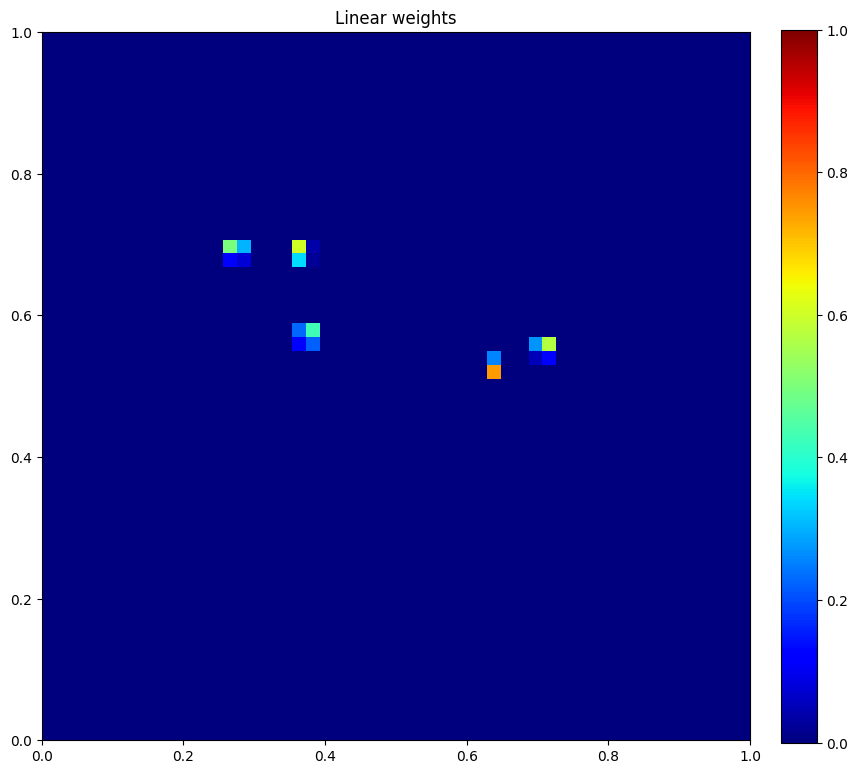

In [12]:
#NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(10, 10))
plt.imshow(u.data[1], vmin=0, vmax=1, cmap="jet", extent=[0,1,0,1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Linear weights")
plt.show()

### Kaiser sinc interpolation

Graham J. Hicks pioneered an approach to address one of the significant challenges in seismic simulation: the accurate and flexible positioning of sources and receivers in finite-difference computational grids. By integrating Kaiser windowed sinc functions into the interpolation process, Hicks' method facilitates arbitrary placement of these elements, overcoming the limitations imposed by the inherent discreteness of computational grids. This technique is especially beneficial in seismic wave propagation models, where precise source and receiver locations are crucial for accurate subsurface imaging.

## Mathematical Basis of the Interpolation

The interpolation of a field value, $f$, at an arbitrary point using the Kaiser windowed sinc function can be mathematically expressed as follows:

$$
f(x) = \sum_{n=-r}^{r} f_n \cdot \text{sinc}\left( \frac{x - x_n}{\Delta x} \right) \cdot w\left( \frac{x - x_n}{\alpha} \right)
$$

where:
- $f_n$ represents the field values at grid points.
- $x$ denotes the arbitrary (non-grid-aligned) position where the field value is interpolated.
- $x_n$ refers to the position of the $n$-th grid point.
- $\Delta x$ is the grid spacing.
- $w(\cdot)$ is the Kaiser window function applied to modulate the sinc function, defined as:
  $$
  w(x) = \frac{I_0\left( \beta \sqrt{1 - \left( \frac{x}{\alpha} \right)^2} \right)}{I_0(\beta)}
  $$
- $I_0$ is the modified Bessel function of the first kind and zero order.
- $\beta$ is the Kaiser window's shape parameter, controlling sidelobe attenuation.
- $\alpha$ is a scaling factor that adjusts the effective width of the window, enhancing the function's ability to interpolate over a wider area without significant loss of accuracy.

## Practical Implications for Seismic Modeling

This interpolation formula is pivotal for improving the fidelity of finite-difference simulations in seismic applications. By allowing for the precise positioning of sources and receivers, it enables more accurate modeling of wave propagation through complex geological structures. The flexibility offered by this method significantly enhances the quality of seismic images, providing clearer insights into the Earth's subsurface.



In [13]:
s = SparseTimeFunction(name="s", grid=grid, npoint=npoint, nt=nt, coordinates=coords, interpolation='sinc')

interp_points = np.concatenate([base+(s1*d1, s2*d2) for (s1, s2) in s._point_support])

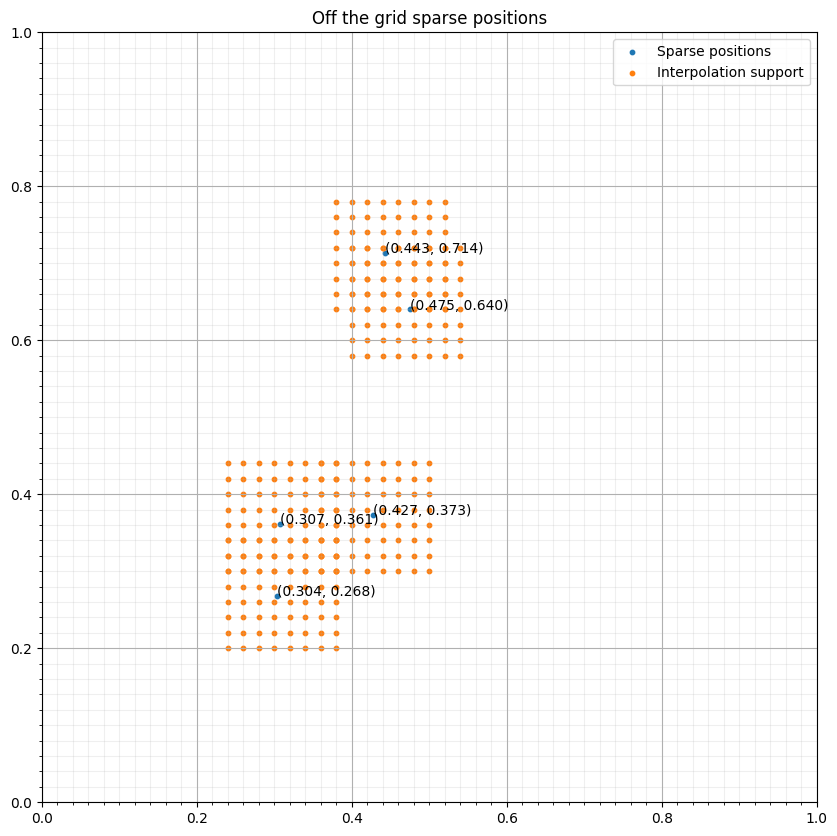

In [14]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.scatter(coords[:, 0], coords[:, 1], s=10, label="Sparse positions")
ax.scatter(interp_points[:, 0], interp_points[:, 1], s=10, label="Interpolation support")
ax.grid(which = "major")
ax.grid(which = "minor", alpha = 0.2)
ax.xaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.yaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.set_title("Off the grid sparse positions")
for i in range(npoint):
    ax.annotate("(%.3f, %.3f)" % (coords[i, 0], coords[i, 1]), coords[i, :])
ax.legend()
plt.show()

In [15]:
print("\n".join([str(s) for s in s.interpolate(f).evaluate]))

Eq(posx, floor((-o_x + s_coords(p_s, 0))/h_x))
Eq(posy, floor((-o_y + s_coords(p_s, 1))/h_y))
Eq(sum, 0.0)
Inc(sum, wsincrsx(p_s, rsx + 3)*wsincrsy(p_s, rsy + 3)*f(t, rsx + posx, rsy + posy))
Eq(s(time, p_s), sum)


In [16]:
print("\n".join([str(s) for s in s.interpolate(f).evaluate]))

Eq(posx, floor((-o_x + s_coords(p_s, 0))/h_x))
Eq(posy, floor((-o_y + s_coords(p_s, 1))/h_y))
Eq(sum, 0.0)
Inc(sum, wsincrsx(p_s, rsx + 3)*wsincrsy(p_s, rsy + 3)*f(t, rsx + posx, rsy + posy))
Eq(s(time, p_s), sum)


In [17]:
f.data.fill(0)
op = Operator([Eq(f.forward, f+1)] + s.interpolate(f))

In [18]:
#NBVAL_IGNORE_OUTPUT
op()
s.data

Operator `Kernel` ran in 0.01 s


Data([[0.        , 0.        , 0.        , 0.        , 0.        ],
      [0.9925686 , 0.9952191 , 0.99392927, 0.9933772 , 0.9967097 ],
      [1.9851372 , 1.9904382 , 1.9878585 , 1.9867544 , 1.9934194 ],
      [2.9777079 , 2.9856577 , 2.9817874 , 2.9801316 , 2.9901292 ],
      [3.9702744 , 3.9808764 , 3.975717  , 3.9735088 , 3.9868388 ],
      [4.9628468 , 4.976095  , 4.9696455 , 4.966884  , 4.9835467 ],
      [5.9554157 , 5.9713154 , 5.963575  , 5.9602633 , 5.9802585 ],
      [6.9479847 , 6.9665327 , 6.957505  , 6.95364   , 6.976965  ],
      [7.940549  , 7.961753  , 7.951434  , 7.9470177 , 7.9736776 ],
      [8.933123  , 8.956971  , 8.945365  , 8.940394  , 8.9703865 ],
      [0.        , 0.        , 0.        , 0.        , 0.        ]],
     dtype=float32)

In [19]:
#NBVAL_IGNORE_OUTPUT
op = Operator(s.inject(u, expr=s))
op()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.3e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

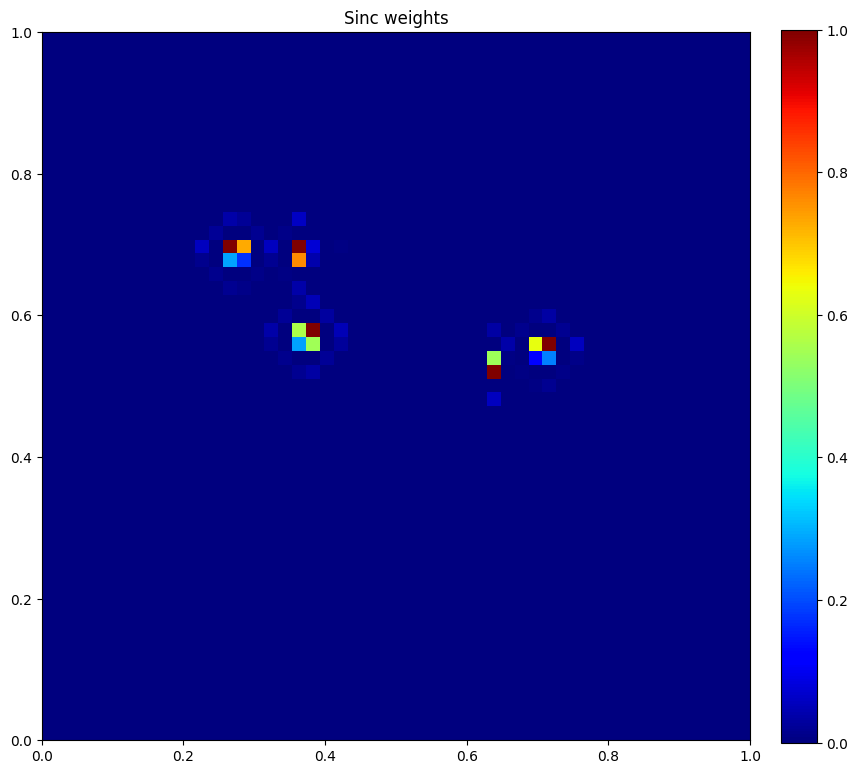

In [20]:
#NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(10, 10))
plt.imshow(u.data[1], vmin=0, vmax=1, cmap="jet", extent=[0,1,0,1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Sinc weights")
plt.show()

## PrecomputedSparseFunction

In some cases, simple linear interpolation may not be sufficient for two main reasons:
- The polynomial approximation isn't accurate enough
- The interpolation coefficients could be precomputed as they are not time-dependent

`PrecomputedSparseFunction` offer the interface to answer these two points by allowing the user to provide arbitrary precomputed interpolation weights over an arbitrary large support. 

To illustrate this capability, we show in the following how to use `PrecomputedSparseFunction` to compute a simple local average over a `4x4` window centered on a sparse point ( average over `[x-1, x, x+1, x+2]` in 1D)


In [21]:
print(PrecomputedSparseFunction.__doc__)


    Tensor symbol representing a sparse array in symbolic equations; unlike
    SparseFunction, PrecomputedSparseFunction uses externally-defined data
    for interpolation.

    Parameters
    ----------
    name : str
        Name of the symbol.
    npoint : int
        Number of sparse points.
    grid : Grid
        The computational domain from which the sparse points are sampled.
    r : int
        Number of gridpoints in each Dimension to interpolate a single sparse
        point to. E.g. `r=2` for linear interpolation.
    coordinates : np.ndarray, optional
        The coordinates of each sparse point.
    gridpoints : np.ndarray, optional
        An array carrying the *reference* grid point corresponding to each
        sparse point.  Of all the gridpoints that one sparse point would be
        interpolated to, this is the grid point closest to the origin, i.e. the
        one with the lowest value of each coordinate Dimension. Must be a
        two-dimensional array of shap

In [22]:
coeffs = np.ones((5, 2, 5))
s = PrecomputedSparseTimeFunction(name="s", grid=grid, npoint=npoint, nt=nt, 
                                  interpolation_coeffs=coeffs,
                                  coordinates=coords, r=2)


pos = tuple(product((-grid.spacing[1], 0, grid.spacing[1],2*grid.spacing[1]),
                    (-grid.spacing[1], 0, grid.spacing[1],2*grid.spacing[1])))
interp_points = np.concatenate([base+p for p in pos])

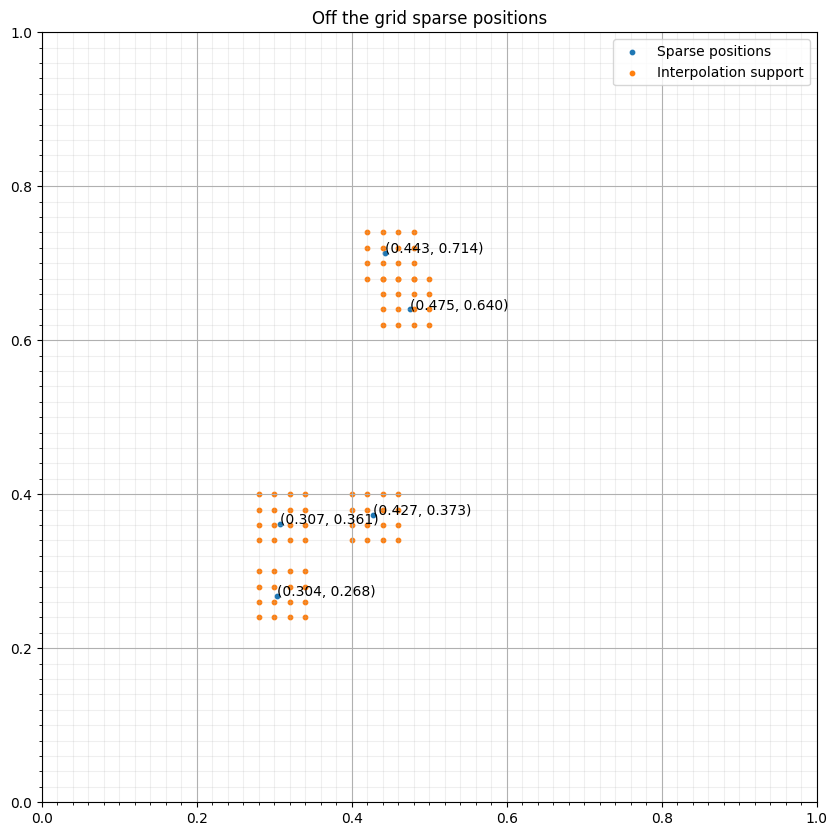

In [23]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.scatter(coords[:, 0], coords[:, 1], s=10, label="Sparse positions")
ax.scatter(interp_points[:, 0], interp_points[:, 1], s=10, label="Interpolation support")
ax.grid(which = "major")
ax.grid(which = "minor", alpha = 0.2)
ax.xaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.yaxis.set_minor_locator(FixedLocator(np.linspace(0, 1, 51)))
ax.set_title("Off the grid sparse positions")
for i in range(npoint):
    ax.annotate("(%.3f, %.3f)" % (coords[i, 0], coords[i, 1]), coords[i, :])
ax.legend()
plt.show()

In [24]:
f.data.fill(0)
op = Operator([Eq(f.forward, f+1)] + s.interpolate(f/16))

In [25]:
#NBVAL_IGNORE_OUTPUT
op()
s.data

Operator `Kernel` ran in 0.01 s


Data([[0., 0., 0., 0., 0.],
      [1., 1., 1., 1., 1.],
      [2., 2., 2., 2., 2.],
      [3., 3., 3., 3., 3.],
      [4., 4., 4., 4., 4.],
      [5., 5., 5., 5., 5.],
      [6., 6., 6., 6., 6.],
      [7., 7., 7., 7., 7.],
      [8., 8., 8., 8., 8.],
      [9., 9., 9., 9., 9.],
      [0., 0., 0., 0., 0.]], dtype=float32)

In [26]:
#NBVAL_IGNORE_OUTPUT
u.data.fill(0)
op = Operator(s.inject(u, expr=s))
op()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=3.6e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

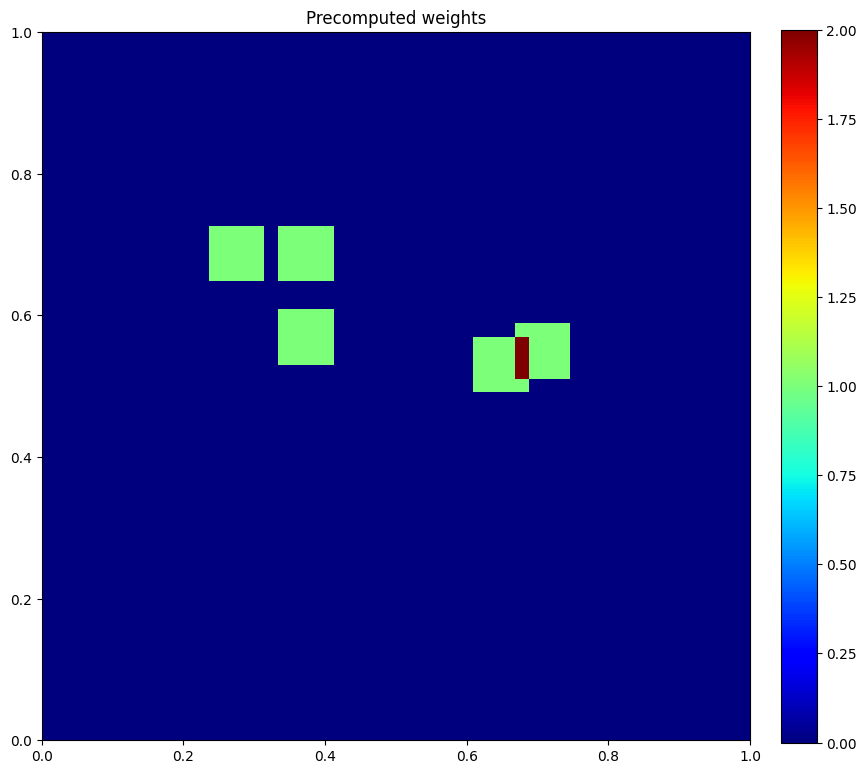

In [27]:
#NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(10, 10))
plt.imshow(u.data[1], vmin=0, vmax=2, cmap="jet", extent=[0,1,0,1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Precomputed weights")
plt.show()